# Transformer Model
Training a transformer model to forecast time series sequence of stock closing price  
Using 10 timesteps to forecast 1 forward timestep

Imports

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import time
import math
import matplotlib.pyplot as plt

Load data and set global variables

In [8]:
# Construct the file path
file_name = "ESM21.csv"

# Define column names
column_names = ['Time','Open', 'High', 'Low', 'Close','Volumes']

# Load the CSV file into a pandas DataFrame
data = pd.read_csv(file_name, names=column_names)

# Take only the last 50,000 rows
df = data.tail(50000)

# Display the modified DataFrame
print(df.tail(300))

                       Time     Open     High      Low    Close  Volumes
119600  2021.06.18.03:55:00  4222.00  4222.50  4221.75  4222.50       21
119601  2021.06.18.03:56:00  4222.25  4222.25  4222.00  4222.00        3
119602  2021.06.18.03:57:00  4221.25  4221.25  4221.25  4221.25        5
119603  2021.06.18.03:58:00  4221.25  4221.25  4220.50  4220.50       22
119604  2021.06.18.03:59:00  4220.50  4220.50  4219.50  4220.00       47
...                     ...      ...      ...      ...      ...      ...
119895  2021.06.18.09:25:00  4190.75  4193.50  4190.75  4191.25      176
119896  2021.06.18.09:26:00  4191.25  4191.50  4190.50  4190.50       26
119897  2021.06.18.09:27:00  4190.50  4191.50  4188.75  4190.00      192
119898  2021.06.18.09:28:00  4190.00  4191.00  4188.25  4189.75      177
119899  2021.06.18.09:29:00  4189.50  4189.75  4185.00  4185.50      454

[300 rows x 6 columns]


In [ ]:
close = np.array(df['Close'])
logreturn = np.diff(np.log(close)) # Transform closing price to log returns, instead of using min-max scaler

csum_logreturn = logreturn.cumsum() # Cumulative sum of log returns

In [ ]:
input_window = 10 # number of input steps
output_window = 1 # number of prediction steps, in this model its fixed to one
batch_size = 250
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Plot shows the reduced scale of the closing prices

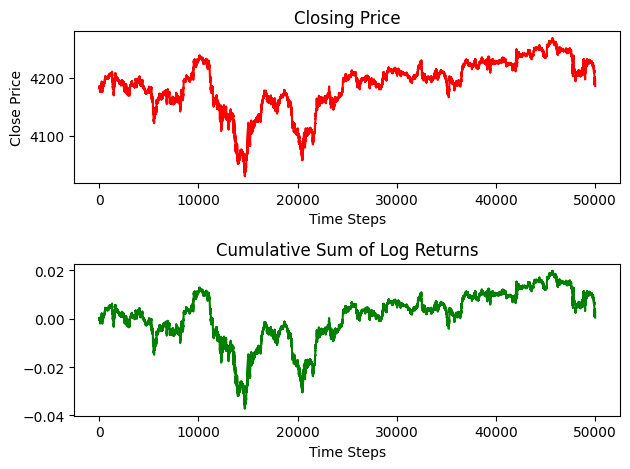

In [ ]:
fig, axs = plt.subplots(2, 1)
axs[0].plot(close, color='red')
axs[0].set_title('Closing Price')
axs[0].set_ylabel('Close Price')
axs[0].set_xlabel('Time Steps')

axs[1].plot(csum_logreturn, color='green')
axs[1].set_title('Cumulative Sum of Log Returns')
axs[1].set_xlabel('Time Steps')

fig.tight_layout()
plt.show()

Positional Encoder

In [ ]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

Transformer Model

In [ ]:
class TransAm(nn.Module):
    def __init__(self, feature_size=250, num_layers=1, dropout=0.1):
        super(TransAm, self).__init__()
        self.model_type = 'Transformer'

        self.src_mask = None
        self.pos_encoder = PositionalEncoding(feature_size)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=feature_size, nhead=10, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(feature_size,1)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self,src):
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        src = self.pos_encoder(src)
        output = self.transformer_encoder(src,self.src_mask)
        output = self.decoder(output)
        return output

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

Window function, split data into sequence window

In [ ]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+output_window:i+tw+output_window]
        inout_seq.append((train_seq ,train_label))
    return torch.FloatTensor(inout_seq)

Split data in training and testing, prepared in windowed sequences and pass through GPU

In [ ]:
def get_data(data, split):
    """Split ratio of training data"""

    series = data

    split = round(split*len(series))
    train_data = series[:split]
    test_data = series[split:]

    train_data = train_data.cumsum()
    train_data = 2*train_data # Training data augmentation, increase amplitude for the model to better generalize.(Scaling by 2 is aribitrary)
                              # Similar to image transformation to allow model to train on wider data sets

    test_data = test_data.cumsum()

    train_sequence = create_inout_sequences(train_data,input_window)
    train_sequence = train_sequence[:-output_window]

    test_data = create_inout_sequences(test_data,input_window)
    test_data = test_data[:-output_window]

    return train_sequence.to(device), test_data.to(device)

Split into training batches

In [ ]:
def get_batch(source, i, batch_size):
    seq_len = min(batch_size, len(source) - 1 - i)
    data = source[i:i+seq_len]
    input = torch.stack(torch.stack([item[0] for item in data]).chunk(input_window, 1))
    target = torch.stack(torch.stack([item[1] for item in data]).chunk(input_window, 1))
    return input, target

Training function

In [ ]:
def train(train_data):
    model.train() # Turn on the evaluation mode
    total_loss = 0.
    start_time = time.time()

    for batch, i in enumerate(range(0, len(train_data) - 1, batch_size)):
        data, targets = get_batch(train_data, i,batch_size)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.7)
        optimizer.step()

        total_loss += loss.item()
        log_interval = int(len(train_data) / batch_size / 5)
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.10f} | {:5.2f} ms | '
                  'loss {:5.7f}'.format(
                    epoch, batch, len(train_data) // batch_size, scheduler.get_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss))
            total_loss = 0
            start_time = time.time()

Evaluation function for model after training

In [ ]:
def evaluate(eval_model, data_source):
    eval_model.eval() # Turn on the evaluation mode
    total_loss = 0.
    eval_batch_size = 1000
    with torch.no_grad():
        for i in range(0, len(data_source) - 1, eval_batch_size):
            data, targets = get_batch(data_source, i, eval_batch_size)
            output = eval_model(data)
            total_loss += len(data[0])* criterion(output, targets).cpu().item()
    return total_loss / len(data_source)

Function to forecast 1 time step from window sequence

In [ ]:
def model_forecast(model, seqence):
    model.eval()
    total_loss = 0.
    test_result = torch.Tensor(0)
    truth = torch.Tensor(0)

    seq = np.pad(seqence, (0, 3), mode='constant', constant_values=(0, 0))
    seq = create_inout_sequences(seq, input_window)
    seq = seq[:-output_window].to(device)

    seq, _ = get_batch(seq, 0, 1)
    with torch.no_grad():
        for i in range(0, output_window):
            output = model(seq[-output_window:])
            seq = torch.cat((seq, output[-1:]))

    seq = seq.cpu().view(-1).numpy()

    return seq

Function to forecast entire sequence

In [ ]:
def forecast_seq(model, sequences):
    """Sequences data has to been windowed and passed through device"""
    start_timer = time.time()
    model.eval()
    forecast_seq = torch.Tensor(0)
    actual = torch.Tensor(0)
    with torch.no_grad():
        for i in range(0, len(sequences) - 1):
            data, target = get_batch(sequences, i, 1)
            output = model(data)
            forecast_seq = torch.cat((forecast_seq, output[-1].view(-1).cpu()), 0)
            actual = torch.cat((actual, target[-1].view(-1).cpu()), 0)
    timed = time.time()-start_timer
    print(f"{timed} sec")

    return forecast_seq, actual

Prepare data for training model

In [ ]:
train_data, val_data = get_data(logreturn, 0.6) # 60% train, 40% test split
model = TransAm().to(device)

<ipython-input-8-6c915dbbfe42>:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  return torch.FloatTensor(inout_seq)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Model parameters

In [ ]:
criterion = nn.MSELoss() # Loss function
lr = 0.00005 # learning rate

optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

epochs =  100 # Number of epochs

Training loop

In [ ]:
for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train(train_data)

    if(epoch % epochs == 0): # Valid model after last training epoch
        val_loss = evaluate(model, val_data)
        print('-' * 80)
        print('| end of epoch {:3d} | time: {:5.2f}s | valid loss: {:5.7f}'.format(epoch, (time.time() - epoch_start_time), val_loss))
        print('-' * 80)

    else:
        print('-' * 80)
        print('| end of epoch {:3d} | time: {:5.2f}s'.format(epoch, (time.time() - epoch_start_time)))
        print('-' * 80)

    scheduler.step()


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:402: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch   1 |    23/  119 batches | lr 0.0000500000 | 613.78 ms | loss 0.1860449
| epoch   1 |    46/  119 batches | lr 0.0000500000 | 455.76 ms | loss 0.0191621
| epoch   1 |    69/  119 batches | lr 0.0000500000 | 644.96 ms | loss 0.0104595
| epoch   1 |    92/  119 batches | lr 0.0000500000 | 588.91 ms | loss 0.0073137
| epoch   1 |   115/  119 batches | lr 0.0000500000 | 465.95 ms | loss 0.0065618
--------------------------------------------------------------------------------
| end of epoch   1 | time: 66.00s
--------------------------------------------------------------------------------
| epoch   2 |    23/  119 batches | lr 0.0000451250 | 467.87 ms | loss 0.0045572
| epoch   2 |    46/  119 batches | lr 0.0000451250 | 488.71 ms | loss 0.0047032
| epoch   2 |    69/  119 batches | lr 0.0000451250 | 553.41 ms | loss 0.0038282
| epoch   2 |    92/  119 batches | lr 0.0000451250 | 501.41 ms | loss 0.0037758
| epoch   2 |   115/  119 batches | lr 0.0000451250 | 498.57 ms | loss 0.00

In [ ]:
test_result, truth = forecast_seq(model, val_data)

41.82202386856079 sec


Plot forecasted sequence vs actual

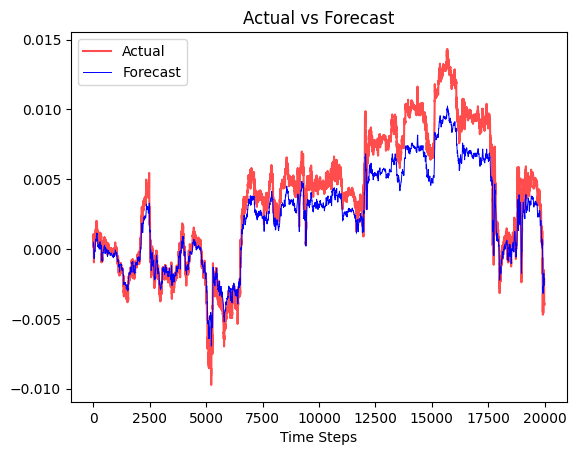

In [ ]:
plt.plot(truth, color='red', alpha=0.7)
plt.plot(test_result, color='blue', linewidth=0.7)
plt.title('Actual vs Forecast')
plt.legend(['Actual', 'Forecast'])
plt.xlabel('Time Steps')
plt.show()

Test random sequence

In [ ]:
# Create a DataFrame
df = pd.DataFrame({'truth': truth.numpy(), 'test_result': test_result.numpy()})

df['next_day_test_result'] = df['test_result'].shift(-1)

# Set the position to NaN for the first day
df['position'] = np.nan

# Set the position to 1 if the next day's test_result is greater than today's test_result
df.loc[df['next_day_test_result'] > df['test_result'], 'position'] = 1

# Fill NaN values with -1 (if next day's test_result is not greater)
df['position'].fillna(-1, inplace=True)

# Drop the 'next_day_test_result' column as it's no longer needed
df.drop(columns=['next_day_test_result'], inplace=True)

pd.options.display.float_format = '{:.7f}'.format

# Create a new column called 'returns' which is the difference between truth today and truth yesterday
df['returns'] = df['truth'].diff()

# Create a new column called 'returns' which is the difference between truth today and truth yesterday
df['predicted returns'] = df['test_result'].diff()

# Create a new column called 'PnL' which is the product of 'returns' and 'position'
df['PnL'] = df['returns'] * df['position']

# Initial wealth
initial_wealth = 100

# Calculate wealth based on PnL values
wealth = [initial_wealth]
for i in range(1, len(df)):
    wealth.append(wealth[-1] * (1 + df['PnL'][i]))

# Add the wealth column to the DataFrame
df['wealth'] = wealth

# Display the updated DataFrame
print(df)



           truth  test_result   position    returns  predicted returns  \
0      0.0010098    0.0002827  1.0000000        NaN                NaN   
1      0.0009504    0.0003768  1.0000000 -0.0000594          0.0000941   
2      0.0010691    0.0004137  1.0000000  0.0001187          0.0000370   
3      0.0009504    0.0004494  1.0000000 -0.0001187          0.0000356   
4      0.0007723    0.0004668  1.0000000 -0.0001781          0.0000174   
...          ...          ...        ...        ...                ...   
19983 -0.0038703   -0.0022144 -1.0000000  0.0001193         -0.0000789   
19984 -0.0039300   -0.0023001 -1.0000000 -0.0000597         -0.0000857   
19985 -0.0036914   -0.0023818 -1.0000000  0.0002386         -0.0000817   
19986 -0.0038703   -0.0024643 -1.0000000 -0.0001790         -0.0000825   
19987 -0.0039896   -0.0026062 -1.0000000 -0.0001193         -0.0001419   

             PnL      wealth  
0            NaN 100.0000000  
1     -0.0000594  99.9940630  
2      0.0001187 1

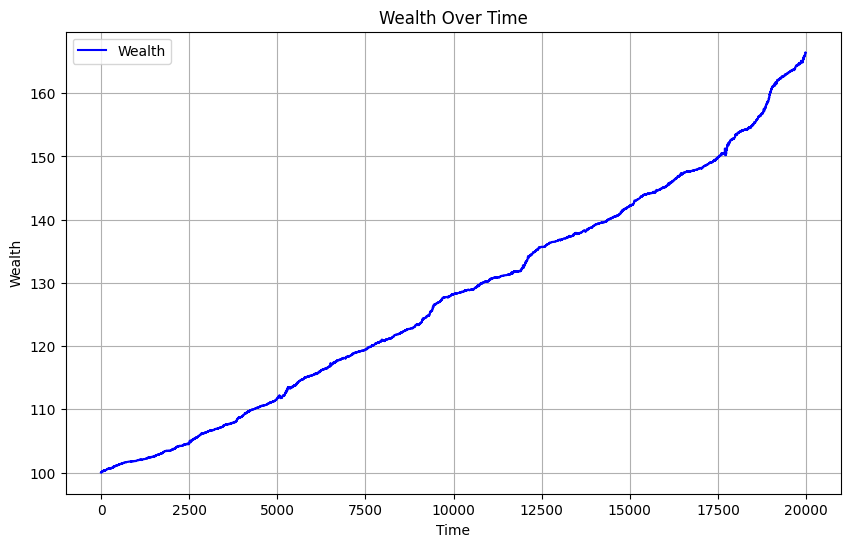

In [ ]:
import matplotlib.pyplot as plt

# Plot the wealth column
plt.figure(figsize=(10, 6))
plt.plot(df['wealth'], label='Wealth', color='blue')
plt.xlabel('Time')
plt.ylabel('Wealth')
plt.title('Wealth Over Time')
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
# Calculate the percentage of rows where PnL >= 0
percentage_positive_PnL = (df['PnL'] >= 0).mean() * 100

# Print the percentage
print("Percentage of rows where PnL is greater than or equal to 0:", percentage_positive_PnL, "%")


Percentage of rows where PnL is greater than or equal to 0: 69.46167700620373 %


In [ ]:
# Compute the number of times the position switched
num_switches = (df['position'] != df['position'].shift(1)).sum()

# Print the result
print("Number of position switches:", num_switches)


Number of position switches: 3686
